# Replay based Class Incremental Learning (CIL) with PyTorch

This notebook covers a simplified implementation of class incremental learning (CIL) using replay-based techniques. The goal of CIL is to learn a model that can incrementally learn new classes without forgetting the previously learned classes. In this notebook, we will use a replay-based technique to store and replay the data from the previous classes to prevent forgetting.

To do this, we will use the following steps:
Train base model on the first set of two classes e.g. 0 and 1 for 100 epochs utilising Stochastic Gradient Descent (SGD) with a learning rate of 0.01 and momentum of 0.9.
After training our base model, we will then store a subset of our data from the first two classes in a replay buffer, let $R_i$ be the replay buffer for class $i$ and $D_i$ be the training data for class $i$ up to that training step inclusive of all previous classes.

We denote: $R_i \subseteq D_i$

And: $D_i = \cup_{x = 0}^{i}d_x$

Where $d_x$ is the data for class $x$.

i.e. the replay buffer will only contain a variant subset of the data from the previous classes as opposed to all the data of that class which
we can change to determine the effect of the replay buffer size on the model's performance.

From this point onwards, we will incrementally train our model utilising Class-Incremental Learning (CIL) by training on the class and replaying the data from the previous classes.

This model will utilise a standard implementation of a ResNet18 CNN model with a single fully connected layer at the end to classify the images. It will also be trained on the CIFAR-10 dataset, which contains 60,000 32x32 colour images in 10 classes, with 6,000 images per class.

In [170]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import time
from cifar import load_cifar10_data, split_into_classes, get_class_indexes 
from torch.utils.data import DataLoader

# Path to the dataset
DATASET_PATH = 'cifar-10-batches-py' 
CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Define custom ResNet18 model for CIFAR10

In this case we chance the convolution kernel to 3x3 and the stride to 1 for the first layer. We will also change the number of classes on the final softmax layer to 10 to match the CIFAR10 dataset.

In [171]:
class ResNet18CIFAR(torch.nn.Module):
    def __init__(self):
        super(ResNet18CIFAR, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        # change the first layer to accept 32x32 images with 3 channels rather than 224x224 images
        # check the size of the input layer
        print("|| conv1 weight size: ", self.resnet.conv1.weight.size())
        print("|| fc weight size: ", self.resnet.fc.weight.size())
        self.resnet.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # change input layer to accept 32x32 images by utilising smaller convolutional kernel
        self.resnet.fc = torch.nn.Linear(512, 10)
        # the architecture is already built to support 10 classes
        self.resnet.maxpool = torch.nn.Identity()
        # maxpool worsens performance and is unnecessary for small image sizes
        

    def forward(self, x):
        return self.resnet(x)
    
# make a resnet model
model = ResNet18CIFAR()
model.eval()

|| conv1 weight size:  torch.Size([64, 3, 7, 7])
|| fc weight size:  torch.Size([1000, 512])


Using cache found in /dcs/21/u2145461/.cache/torch/hub/pytorch_vision_v0.10.0
/local/java/python-ml/22-12-21-python3.9/lib64/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/local/java/python-ml/22-12-21-python3.9/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet18CIFAR(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
       

### Data Load and Preprocessing into separate class datasets

Utilise the CIFAR-10 dataset alongside a prebuilt dataloader to load the data into separate class datasets.
(Krishi's code)

In [172]:
train_data, train_labels, test_data, test_labels = load_cifar10_data(DATASET_PATH)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# split the data into 10 classes by doing sort by key where in the keys are the labels and the values are the data
train_split = {cls: [] for cls in CLASSES}
for img, label in zip(train_data, train_labels):
    train_split[CLASSES[label]].append(img)
    
# this makes more sense to me, effectively indexes 0-5000 are all airplanes, 5000-10000 are all automobiles etc
test_split = {cls: [] for cls in CLASSES}
for img, label in zip(test_data, test_labels):
    test_split[CLASSES[label]].append(img)


# The Algorithm

Train initial model on the first two classes.

For each class $i$ in the dataset:

1. Train the model on the current class $i$ and replay the data from the previous classes.

2. Store a subset of the data from the current class $i$ in the replay buffer $R_i$.

3. Evaluate the model on the test set.

4. Increment the number of classes seen.

5. Repeat steps 1-4 for each class in the dataset.

Note: the size of the replay buffer is a hyperparameter that can be tuned to determine the effect of the replay buffer size on the model's performance.

The following hyperparameters will be used in this notebook:

- Epochs: 100 (per class)
- Learning rate: 0.00005
- Momentum: 0.9
- Batch size: 64
- Replay buffer size: Variant (e.g. 2000, 4000, 6000, 8000, 10000 per class)

### References

1. [Continual Learning with Deep Architectures: A Review](https://arxiv.org/abs/1907.04471)

2. [RECALL Replay Based Continual Learning in Semantic Segmentation](https://openaccess.thecvf.com/content/ICCV2021/papers/Maracani_RECALL_Replay-Based_Continual_Learning_in_Semantic_Segmentation_ICCV_2021_paper.pdf)

In [173]:
replay_memory = {cls: [] for cls in CLASSES} 
learning_rate = 0.00005
momentum = 0.9
batch_size = 256
epochs = 100
loss_function = torch.nn.CrossEntropyLoss()
# output is softmax gaussian probability distribution, so cross entropy loss is appropriate
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
airplane_accuracies = []
automobile_accuracies = []

# firstly, train on airplanes and automobiles for 100 epochs utilising Adam
current_train_data = train_split['airplane'] + train_split['automobile']
current_train_labels = [0] * len(train_split['airplane']) + [1] * len(train_split['automobile'])

# convert to tensors
current_train_data = torch.tensor(current_train_data).float()
current_train_labels = torch.tensor(current_train_labels)

if torch.cuda.is_available():
    model = model.cuda()
    current_train_data = current_train_data.cuda()
    current_train_labels = current_train_labels.cuda()

# we have figured out CUDA for jupyter notebooks :)
for i in range(epochs):
    for j in range(0, len(current_train_data), batch_size):
        optimiser.zero_grad()
        images = current_train_data[j:j+batch_size]
        labels = current_train_labels[j:j+batch_size]
        
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()
        if (j == 0):
            losses.append(loss.item())
            # calculate accuracy
            correct_airplanes = 0
            correct_automobiles = 0
            total_airplanes = len(train_split['airplane'])
            total_automobiles = len(train_split['automobile'])
            with torch.no_grad():
                for k in range(0, len(current_train_data), batch_size):
                    image = current_train_data[k:k+batch_size]
                    labels = current_train_labels[k:k+batch_size]
                    outputs = model(image)
                    _, predicted = torch.max(outputs.data, 1)
                    correct_airplanes += (predicted[labels == 0] == labels[labels == 0]).sum().item()
                    correct_automobiles += (predicted[labels == 1] == labels[labels == 1]).sum().item()
            airplane_accuracies.append(correct_airplanes/total_airplanes * 100)
            automobile_accuracies.append(correct_automobiles/total_automobiles * 100)
            print(f"Epoch {i+1}/{epochs}, Loss: {loss.item():.2f}, Accuracy: Airplanes: {correct_airplanes/total_airplanes * 100:.2f}% Automobiles: {correct_automobiles/total_automobiles * 100:.2f}%")
            
# save the model
torch.save(model.state_dict(), 'resnet18_cifar10_airplane_automobile.pth')

Epoch 1/100, Loss: 287.58, Accuracy: Airplanes: 100.00% Automobiles: 0.00%
Epoch 2/100, Loss: 810.89, Accuracy: Airplanes: 0.00% Automobiles: 100.00%
Epoch 3/100, Loss: 30.59, Accuracy: Airplanes: 0.00% Automobiles: 100.00%
Epoch 4/100, Loss: 5.49, Accuracy: Airplanes: 0.00% Automobiles: 100.00%
Epoch 5/100, Loss: 2.28, Accuracy: Airplanes: 0.04% Automobiles: 100.00%
Epoch 6/100, Loss: 1.61, Accuracy: Airplanes: 10.36% Automobiles: 99.92%
Epoch 7/100, Loss: 1.45, Accuracy: Airplanes: 17.82% Automobiles: 99.76%
Epoch 8/100, Loss: 1.31, Accuracy: Airplanes: 24.94% Automobiles: 99.54%
Epoch 9/100, Loss: 1.23, Accuracy: Airplanes: 30.04% Automobiles: 99.36%
Epoch 10/100, Loss: 1.17, Accuracy: Airplanes: 32.78% Automobiles: 99.30%
Epoch 11/100, Loss: 1.11, Accuracy: Airplanes: 36.10% Automobiles: 99.14%
Epoch 12/100, Loss: 1.07, Accuracy: Airplanes: 37.90% Automobiles: 99.12%
Epoch 13/100, Loss: 1.03, Accuracy: Airplanes: 41.00% Automobiles: 98.96%
Epoch 14/100, Loss: 1.00, Accuracy: Airpla

### Initial Results for two classes

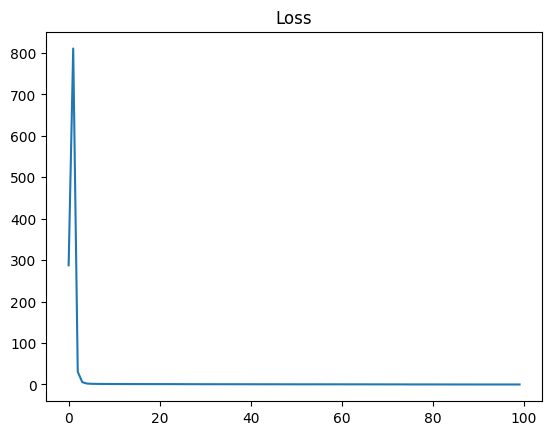

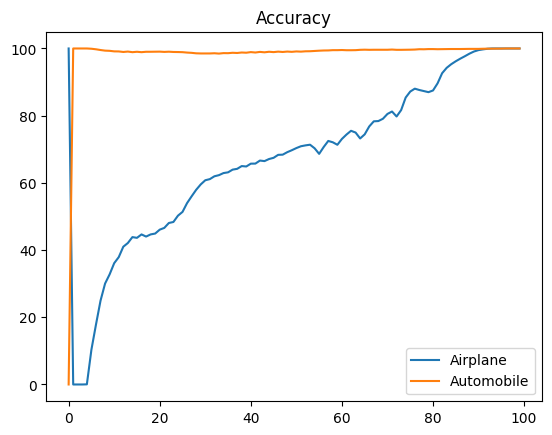

In [174]:
# plot the loss and accuracy
# fix axes labels
plt.plot(losses)
plt.title('Loss')
plt.show()

# show airplane and automobile accuracies
plt.plot(airplane_accuracies, label='Airplane')
plt.plot(automobile_accuracies, label='Automobile')
plt.title('Accuracy')
plt.legend()
plt.show()

## Now let's take the model and try to train it to identify birds!

For the first test we just assume that the replay buffer is just the all the data from the previous classes.
(we will adjust this later)

In fact, start off by just training the model on only birds to see the effects of catastrophic forgetting and how this can be mitigated.

In [177]:
#del model
#del current_train_data
#del current_train_labels

# load model and train on birds
#model = ResNet18CIFAR()
#model.load_state_dict(torch.load('resnet18_cifar10_airplane_automobile.pth', map_location=torch.device('cuda')))

current_train_data = train_split['airplane'] + train_split['automobile'] + train_split['bird']
current_train_labels = [0] * len(train_split['airplane']) + [1] * len(train_split['automobile']) + [2] * len(train_split['bird'])

# fill bird accuracies with 0s for the first 100 epochs
bird_accuracies = []
for i in range(100):
    bird_accuracies.append(0)

current_train_data = torch.tensor(current_train_data).float()
current_train_labels = torch.tensor(current_train_labels)

if torch.cuda.is_available():
    model = model.cuda()
    current_train_data = current_train_data.cuda()
    current_train_labels = current_train_labels.cuda()

for i in range(epochs):
    for j in range(len(train_split['airplane']) + len(train_split['automobile']), len(current_train_data), batch_size):
        optimiser.zero_grad()
        images = current_train_data[j:j+batch_size]
        labels = current_train_labels[j:j+batch_size]
        
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()
        if (j == len(train_split['airplane']) + len(train_split['automobile'])):
            losses.append(loss.item())
            # calculate accuracy
            correct_airplanes = 0
            correct_automobiles = 0
            correct_birds = 0
            total_airplanes = len(train_split['airplane'])
            total_automobiles = len(train_split['automobile'])
            total_birds = len(train_split['bird'])
            with torch.no_grad():
                for k in range(0, len(current_train_data), batch_size):
                    image = current_train_data[k:k+batch_size]
                    labels = current_train_labels[k:k+batch_size]
                    outputs = model(image)
                    _, predicted = torch.max(outputs.data, 1)
                    correct_airplanes += (predicted[labels == 0] == labels[labels == 0]).sum().item()
                    correct_automobiles += (predicted[labels == 1] == labels[labels == 1]).sum().item()
                    correct_birds += (predicted[labels == 2] == labels[labels == 2]).sum().item()
                
            airplane_accuracies.append(correct_airplanes/total_airplanes * 100)
            automobile_accuracies.append(correct_automobiles/total_automobiles * 100)
            bird_accuracies.append(correct_birds/total_birds * 100)
            print(f"Epoch {i+1}/{epochs}, Loss: {loss.item():.2f}, Accuracy: Airplanes: {correct_airplanes/total_airplanes * 100:.2f}% Automobiles: {correct_automobiles/total_automobiles * 100:.2f}% Birds: {correct_birds/total_birds * 100:.2f}%")

Epoch 1/100, Loss: 0.00, Accuracy: Airplanes: 0.00% Automobiles: 0.00% Birds: 100.00%
Epoch 2/100, Loss: 0.00, Accuracy: Airplanes: 0.00% Automobiles: 0.00% Birds: 100.00%
Epoch 3/100, Loss: 0.00, Accuracy: Airplanes: 0.00% Automobiles: 0.00% Birds: 100.00%


KeyboardInterrupt: 

### Results for three classes

Notice we suffer from catastrophic forgetting when not taking into account a replay set. The model is unable to learn the new class without forgetting the previous classes.

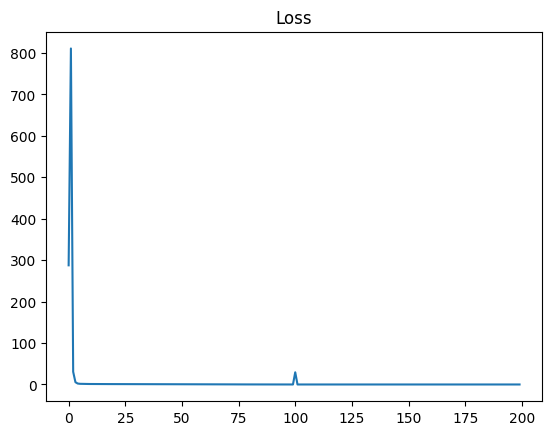

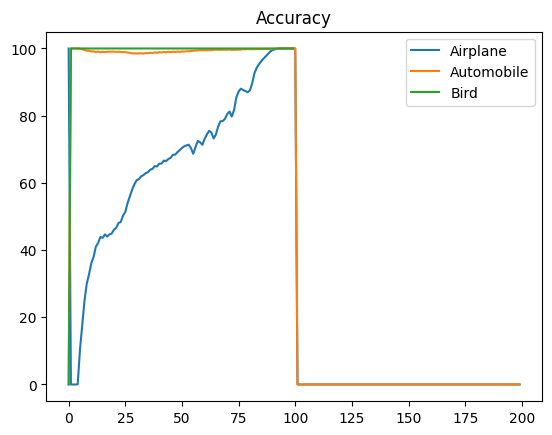

In [ ]:
# plot the loss and accuracy
# fix axes labels
plt.plot(losses)
plt.title('Loss')
plt.show()

# show airplane and automobile accuracies
plt.plot(airplane_accuracies, label='Airplane')
plt.plot(automobile_accuracies, label='Automobile')
plt.plot(bird_accuracies, label='Bird')
plt.title('Accuracy')
plt.legend()
plt.show()